In [3]:
# Imports

import numpy as np
import pandas as pd
import math
import cv2
import time
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
import easyocr
import re

In [4]:
###########################################################################
# CHANGE PATHS HERE DEPENDING ON WHERE YOU STORED THE VIDEO AND LOGS
###########################################################################

# Path where video and logs are stored
model_path = "car_models/model_A/"

# Evaluation video path (download it by right-clicking on the video and saving as .mp4)
video_path = model_path + "evaluation-0-video.mp4"

# Get Evaluation logs
evaluation_df_path = model_path + "evaluation_job_logs/sim-trace/evaluation/0-iteration.csv"
evaluation_df = pd.read_csv(evaluation_df_path)

# Check content of evaluation logs
evaluation_df.head()

,episode,steps,X,Y,yaw,speed,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration
0,0,1.0,-6.582955,-2.398817,165.716189,0.0,10.0,3.0,14,0.0,False,True,0.242192,1,57.862137,7.199,prepare,0.0
1,0,2.0,-6.582821,-2.398845,165.715203,0.0,10.0,3.0,14,1.0,False,True,0.241954,1,57.862137,7.265,in_progress,0.0
2,0,3.0,-6.592715,-2.394681,165.274801,0.0,-30.0,1.0,0,1.0,False,True,0.260304,1,57.862137,7.333,in_progress,0.0
3,0,4.0,-6.611892,-2.380354,163.349683,0.0,10.0,3.0,14,1.0,False,True,0.298546,1,57.862137,7.390,in_progress,0.0
4,0,5.0,-6.639581,-2.354663,159.316615,0.0,20.0,2.0,16,1.0,False,True,0.355908,2,57.862137,7.466,in_progress,0.0


In [15]:
class Simulation():

    def __init__(self, model_path, evaluation_df_path, video_path, simulation_size, reward_components_input={}) -> None:

        # Evaluation dataframe
        self.evaluation_df_path = evaluation_df_path
        self.evaluation_df = pd.read_csv(evaluation_df_path)

        # Model path
        self.model_path = model_path

        # Video
        self.video_path = video_path
        self.video = cv2.VideoCapture(video_path)
        self.total_frame_count = min(int(self.video.get(cv2.CAP_PROP_FRAME_COUNT)), evaluation_df.shape[0])
        self.record_simulation = False               # boolean to control the record state of the simulation (True: recording; False: not recording)

        # DO NOT CHANGE THESE VARIABLES:
        self.deep_racer_fps = 15     # The AWS DeepRacer car takes 15 actions per second, making the animation run at 15 fps
        self.rotate_angle = -90      # Offset angle

        # EXPERIMENT WITH VARIABLES:
        self.frame_rate = 15                 # Variable frame rate to slow-down or speed-up the animation
        self.max_frame_rate = 100            # Maximum variable frame rate allowed
        self.simulation_size = simulation_size        # Size of simulation window
        self.window_w = simulation_size[0]            # Simulation window width
        self.window_h = simulation_size[1]            # Simulation window height
        self.angle_30 = 60                   # Actual angle to display the 30 degrees angle mark in the action space
        self.action_space_radius = 150       # Radius of action space (pixels)
        self.heatmap_attenuation_factor = 1.05 # Attenuation factor for the heatmap (changes how much weight the current action is given for the overall heatmap)
        self.heatmap_gaussian_kernel_size = 60 # Size for the guassian kernel to be used on the action space heatmap
        self.colormap_idx = 20                  # Colormap type (index from 0 to 21, inclusive)

        # AUXILIARY VARIABLES
        self.last_time_checkpoint = 0                # last time checkpoint (controls the temporal spacing between frames)
        self.frame_number = 0                        # current frame
        self.frame_update = 0                        # controls the update of frames while on pause (0:keep on same frame; 1:advance to next frame; -1:go back to previous frame)
        self.overlay_action_space = True             # boolean to control if action space graphic should be overlayed on top of the simulation
        self.overlay_action_space_heatmap = True     # boolean to control if action space heatmap graphic should be overlayed on top of the simulation (only shown if overlay_action_space==True)
        self.overlay_annotations = True              # boolean to control if text should be overlayed on top of the simulation
        self.quit = False                            # boolean to Quit the simulation upon user's request
        self.pause = False                           # boolean to Pause the simulation upon user's request
        self.show_help = False                       # boolean to show the Help menu (list of commands) upon user's request
        self.key_pressed = ""                        # keeps last keyboard key pressed

        # Initialize the action space heatmap
        self.action_space_heatmap = np.zeros((self.window_h, self.window_w), dtype=np.float64)
        self.action_space_pos = (self.window_w//2+50, 170)    # Position to display the center of the action space. Point of (0m/s, 0 degrees)

        # Define colors for text
        self.black = (0,0,0)
        self.white = (255,255,255)
        self.action_color = (0, 150, 255)
        self.speed_color = (0, 255, 0)

        # Reward function plotting
        self.fig = plt.figure(figsize=(7,5))
        self.next_plot_idx = 0
        self.reward_components = {}
        self.num_step_visible_on_plot = 100
        self.plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for reward_component_name, reward_component_expression in reward_components_input.items():
            self.add_reward_component(reward_component_name, reward_component_expression)
        self.setup_reward_components()

        #################################################################
        # ONLY NEEDS TO BE RUN ONCE! (checked automatically by Simulator)
        #################################################################
        # Extract speed from video feed and add its time-series to the evaluation logs
        self.get_speed_timeseries()

    # Generate a Gaussian 2D kernel
    def gaussian_filter(self, n, std):
        gaussian_1d = signal.windows.gaussian(n, std)
        gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
        return gaussian_2d

    # Writes text with a different color border (useful for changing backgrounds as in this simulation)
    def write_text_with_border(self, image, text, pos, font, size, color, border_color, thickness, thickness_increase):
        cv2.putText(image, text, pos, font, size, border_color, thickness+thickness_increase)
        cv2.putText(image, text, pos, font, size, color, thickness)

    # Draw the help menu
    def draw_help_menu(self, image):
        h = self.window_h
        w = self.window_w

        margin = 50
        commands_y_offset = 120
        y_grid_space = 20
        cv2.rectangle(image, (margin,margin), (w-margin,h-margin), (255,255,255), -1)

        # Title
        cv2.putText(image, "Commands", (margin+20,margin+40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0), 1)

        # List of commands to show
        commands_help = [
            "Q: quit",
            "P: pause/resume",
            "H: help menu",
            "N/M: decrease/increase FPS",
            "A: overlay action space",
            "S: overlay action space heatmap",
            "0-9: jump to point in simulation",
            ",/.: go back / advance one frame (while on pause)",
            "Z/X: decrease/increase heatmap attenuation factor",
            "V/B: decrease/increase heatmap gaussian kernel size",
            "F/G: previous/next colormap",
            "C: clear heatmap",
            "T: toggle text notes",
            "R: record simulation"
        ]
        for idx, command_help in enumerate(commands_help):
            cv2.putText(image, command_help, (margin+20,commands_y_offset + idx*y_grid_space), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,0), 1)

    def draw_circle_section(self, image, center, axes, angle, angle_range, color, thickness):
        cv2.ellipse(image, center, axes, angle, angle_range[0], angle_range[1], color, thickness)

    def draw_steer_angle_line(self, image, center, angle, length, color, thickness):
        rad = math.radians(angle)
        pt1 = center
        pt2 = (int(center[0] + length*math.cos(rad)), int(center[1] + length*math.sin(rad)))
        cv2.line(image, pt1, pt2, color, thickness)

    def draw_action(self, image, position, radius, throttle, steer):
        p_x = position[0]
        p_y = position[1]

        x = int(p_x+radius*(throttle/4)*math.cos(math.radians(self.angle_30*steer/30+self.rotate_angle)))
        y = int(p_y+radius*(throttle/4)*math.sin(math.radians(self.angle_30*steer/30+self.rotate_angle)))
        pos = (x, y)
        cv2.circle(image, pos, 4, self.action_color, -1)
        cv2.circle(image, pos, 4, self.black, 1)

        self.write_text_with_border(image, f"( {throttle:.1f}m/s, {steer:.1f} )", (p_x+30, p_y+15), cv2.FONT_HERSHEY_PLAIN, 0.8, self.action_color, self.black, 1, 1)

    def draw_action_space(self, image, position, radius):
        # Create a black image
        action_space_img = np.zeros(image.shape, np.uint8)

        self.draw_circle_section(action_space_img, position, (radius,radius), self.rotate_angle, (-90,90), self.white, -1)                 # Draw white background
        # Draw circle section for each of the m/s markings
        for i in range(0,4):
            self.draw_circle_section(action_space_img, position, (radius*(4-i)//4,radius*(4-i)//4), self.rotate_angle, (-90,90), self.black, 1)    
        
        # Draw steer angle line and the angle annotations
        for i in range(-2,3):
            self.draw_steer_angle_line(action_space_img, position, self.angle_30*i//2 + self.rotate_angle, radius, self.black, 1)
            x = int(position[0]+radius*math.cos(math.radians(self.angle_30*i//2+self.rotate_angle)))
            if i==0: x-=5
            if i<0: x-=33
            y = int(position[1]+radius*math.sin(math.radians(self.angle_30*i//2+self.rotate_angle)))
            self.write_text_with_border(image, str(30*i//2), (x, y), cv2.FONT_HERSHEY_PLAIN, 1, self.white, self.black, 1, 1)

        # Speed labels
        for i in range(0, 5):
            self.write_text_with_border(image, str(4-i), (position[0]-radius*(4-i)//4-5, position[1]+15), cv2.FONT_HERSHEY_PLAIN, 1, self.white, self.black, 1, 1)

        return action_space_img

    def update_action_space_heatmap(self, throttle, steer):
        p_x = self.action_space_pos[0]
        p_y = self.action_space_pos[1]
        x = int(p_x+self.action_space_radius*(throttle/4)*math.cos(math.radians(self.angle_30*steer/30+self.rotate_angle)))
        y = int(p_y+self.action_space_radius*(throttle/4)*math.sin(math.radians(self.angle_30*steer/30+self.rotate_angle)))

        std = self.heatmap_gaussian_kernel_size//6       # This standard deviation gives a good smooth curve at the edge
        gaussian = self.gaussian_filter(self.heatmap_gaussian_kernel_size, std)
        gaussian -= gaussian.min()  # Normalize the guassian
        gaussian /= gaussian.max()
        kh = self.heatmap_gaussian_kernel_size//2 # kernel half
        y1,y2,x1,x2 = y-kh, y+kh, x-kh, x+kh
        if y1 < 0: y1 = 0
        if y2 > self.window_h: y2 = self.window_h
        if x1 < 0: x1 = 0
        if x2 > self.window_w: x2 = self.window_w

        # Attenuate the heatmap
        self.action_space_heatmap /= self.heatmap_attenuation_factor
        # Sum the gaussian for the current action
        self.action_space_heatmap[y1:y2, x1:x2] += gaussian[kh-(y-y1):kh+(y2-y), kh-(x-x1):kh+(x2-x)]
        
        return np.array(self.action_space_heatmap)

    # Display progress bar for the entire simulation at the bottom
    def display_progress_bar(self, image):
        current_x = int(self.window_w * (self.frame_number/self.total_frame_count))
        cv2.rectangle(image, (0, self.window_h-5), (current_x, self.window_h), (0, 255, 0), -1)

    def display_text_annotations(self, frame):

        times_faster = self.frame_rate / self.deep_racer_fps
        all_wheels_on_track = self.evaluation_df.iloc[self.frame_number].get("all_wheels_on_track")
        progress = self.evaluation_df.iloc[self.frame_number].get("progress")
        pause_left = self.evaluation_df.iloc[self.frame_number].get("pause_duration")
        pos_x = self.evaluation_df.iloc[self.frame_number].get("X")
        pos_y = self.evaluation_df.iloc[self.frame_number].get("Y")
        yaw = self.evaluation_df.iloc[self.frame_number].get("yaw")
        closest_waypoint = self.evaluation_df.iloc[self.frame_number].get("closest_waypoint")
        reward = self.evaluation_df.iloc[self.frame_number].get("reward")
        episode_status = self.evaluation_df.iloc[self.frame_number].get("episode_status")
        speed = self.evaluation_df.iloc[self.frame_number].get("speed")
        steps = self.evaluation_df.iloc[self.frame_number].get("steps")
    
        # Track-specific variables:
        y_offset = -45
        if episode_status != "pause":
            self.write_text_with_border(frame, f"State: {episode_status}", (int(self.window_w*0.75), int(self.window_h*0.7+y_offset)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        else:
            self.write_text_with_border(frame, f"State: {episode_status} ({pause_left:.1f}s)", (int(self.window_w*0.75), int(self.window_h*0.7+y_offset)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
            
        self.write_text_with_border(frame, f"Lap progress: {progress:.1f}%", (int(self.window_w*0.75), int(self.window_h*0.7+y_offset+15)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Steps: {steps:.0f}", (int(self.window_w*0.75), int(self.window_h*0.7+y_offset+30)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Closest waypoint: {closest_waypoint}", (int(self.window_w*0.75), int(self.window_h*0.7+y_offset+45)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        
        # Car-specific variables:
        w_perc = 0.02
        h_perc = 0.32
        self.write_text_with_border(frame, "Car variables", (int(self.window_w*w_perc), int(self.window_h*h_perc)), cv2.FONT_HERSHEY_PLAIN, 1, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"All wheels on track: {all_wheels_on_track}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 15)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Position: ({pos_x:.1f}, {pos_y:.1f})", (int(self.window_w*w_perc), int(self.window_h*h_perc + 30)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Yaw: {yaw:.1f}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 45)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Speed: {speed:.2f}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 60)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.speed_color, self.black, 1, 1)

        # # Reward function factors:
        # w_perc = 0.02
        # h_perc = 0.5
        # self.write_text_with_border(frame, "Reward function", (int(self.window_w*w_perc), int(self.window_h*h_perc)), cv2.FONT_HERSHEY_PLAIN, 1, self.white, self.black, 1, 1)
        # self.write_text_with_border(frame, f"Reward: {reward:.2f}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 60)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        # for reward_factor in self.reward_function_factors():
        
        #     self.write_text_with_border(frame, f"All wheels on track: {all_wheels_on_track}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 15)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        # self.write_text_with_border(frame, f"Position: ({pos_x:.1f}, {pos_y:.1f})", (int(self.window_w*w_perc), int(self.window_h*h_perc + 30)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        # self.write_text_with_border(frame, f"Yaw: {yaw:.1f}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 45)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        # self.write_text_with_border(frame, f"Reward: {reward:.2f}", (int(self.window_w*w_perc), int(self.window_h*h_perc + 60)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        
        # Simulation-specific variables:
        w_perc = 0.02
        h_perc = 0.78
        self.write_text_with_border(frame, "Simulation variables", (int(self.window_w*w_perc), int(self.window_h*h_perc)), cv2.FONT_HERSHEY_PLAIN, 1, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Heatmap attenuation factor: {self.heatmap_attenuation_factor:.2f}", (int(self.window_w*w_perc), int(self.window_h*h_perc+15)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)
        self.write_text_with_border(frame, f"Heatmap gaussian size: {self.heatmap_gaussian_kernel_size}", (int(self.window_w*w_perc), int(self.window_h*h_perc+30)), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)

        # Print footnote details (FPS, frame count, Help)
        self.write_text_with_border(frame, f"FPS {self.frame_rate} ({times_faster:.1f}x) | Frame {self.frame_number} | H (help) | Q (quit)", (self.window_w//2-10, self.window_h-15), cv2.FONT_HERSHEY_PLAIN, 0.8, self.white, self.black, 1, 1)


    def change_recording_state(self, current_recording_state):
            if current_recording_state:
                # if was recording before, then stop recording and save file
                self.record_video_obj.release()
            else:
                # if no recording was being done, then start recording
                date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
                video_path = model_path + f"deepracer_analysis_{date_str}.mp4"
                self.record_video_obj = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'MP4V'), self.frame_rate, (self.simulation_size)) 
        
            # change state
            self.record_simulation = not self.record_simulation

    def listen_for_key_strokes(self):
        # Wait 1 milisecond for a key to be pressed
        self.key_pressed = cv2.waitKey(1)

        if self.key_pressed in [ord('p'), ord('P')]:
            self.pause = not self.pause
        if self.key_pressed in [ord('h'), ord('H')]:
            self.show_help = not self.show_help
            self.pause = self.show_help
        if self.key_pressed in [ord('q'), ord('Q')]:
            self.quit = True
        if self.key_pressed == ord('.'):
            if self.frame_number < self.total_frame_count-1:
                self.frame_update = 1
        if self.key_pressed == ord(','):
            if self.frame_number >= 1:
                self.frame_update = -1
        if self.key_pressed in [ord('z'), ord('Z')]:
            if self.heatmap_attenuation_factor > 1:
                self.heatmap_attenuation_factor -= 0.01
        if self.key_pressed in [ord('x'), ord('X')]:
            if self.heatmap_attenuation_factor < 1.2:
                self.heatmap_attenuation_factor += 0.01
        if self.key_pressed in [ord('v'), ord('V')]:
            if self.heatmap_gaussian_kernel_size > 30:
                self.heatmap_gaussian_kernel_size -= 5
        if self.key_pressed in [ord('b'), ord('B')]:
            if self.heatmap_gaussian_kernel_size < 100:
                self.heatmap_gaussian_kernel_size += 5
        if self.key_pressed in [ord('c'), ord('C')]:    # Clear action space heatmap
            self.action_space_heatmap = np.zeros((self.window_h, self.window_w), dtype=np.float64) # reset heatmap
        if self.key_pressed in [ord(str(i)) for i in range(0, 10)]:
            set_progress = int(chr(self.key_pressed))
            # Define the current frame as a percentage. If user clicked on "2" then simulation resumes at 20% of completion
            self.frame_number = int(self.total_frame_count * set_progress/10.)
            self.clear_plots()
        if self.key_pressed in [ord('t'), ord('T')]:
            self.overlay_annotations = not self.overlay_annotations
        if self.key_pressed in [ord('r'), ord('R')]:
            self.change_recording_state(self.record_simulation)
        if self.key_pressed in [ord('f'), ord('F')]:
            if self.colormap_idx > 0:
                self.colormap_idx -= 1
        if self.key_pressed in [ord('g'), ord('G')]:
            if self.colormap_idx <= 20:
                self.colormap_idx += 1

    def listen_for_key_strokes_after_pause(self):
        if self.key_pressed in [ord('n'), ord('N')]:
            if self.frame_rate > 1:
                self.frame_rate -= 1
        if self.key_pressed in [ord('m'), ord('M')]:
            if self.frame_rate < self.max_frame_rate:
                self.frame_rate += 1
        if self.key_pressed in [ord('a'), ord('A')]:
            self.overlay_action_space = not self.overlay_action_space
        if self.key_pressed in [ord('s'), ord('S')]:
            self.overlay_action_space_heatmap = not self.overlay_action_space_heatmap
    
    def get_speed_timeseries(self):
        # check if speed timeseries was already collected
        if "speed" in self.evaluation_df.columns:
            return
        
        print("Getting the speed timeseries from video using OCR. This might a few minutes...")
        self.ocr_reader = easyocr.Reader(['en'], gpu=True)      # If GPU not found, CPU is used by default
        
        self.frame_number = 0
        speed_timeseries = []
        
        while self.frame_number < self.total_frame_count:
            self.video.set(cv2.CAP_PROP_POS_FRAMES, self.frame_number-1)
            success, frame = self.video.read()
            if not success:
                print(f"Error reading frame {self.frame_number}.")

            speed_box = cv2.cvtColor(frame[422:442, 21:65], cv2.COLOR_BGR2GRAY)    # range where the speed shows in the video feed
            scale = 2
            speed_box = cv2.resize(speed_box, (speed_box.shape[1]*scale, speed_box.shape[0]*scale))
            text_reader = self.ocr_reader.readtext(speed_box)   # reads the speed
            if text_reader:     # if any text recognized, then use it, else use last speed value
                speed = float(text_reader[0][1])                    # get speed from the OCR returned object and parse to float
                if speed > 100: speed /= 100             # sometimes the OCR does not read the decimal place dot, and so we need to control for this edge case
            
            speed_timeseries.append(speed)

            if self.frame_number % 100 == 0:
                print(f"{self.frame_number} / {self.total_frame_count}")
            
            self.frame_number += 1


        self.evaluation_df.insert(5, "speed", speed_timeseries)
        # Overwrite with new 'speed' column
        self.evaluation_df.to_csv(self.evaluation_df_path, index=False)

        print("Speed timeseries retrieved and saved.")

    def add_reward_component(self, reward_component_name, reward_component_expression):

        # self.fig.canvas.draw()
        self.reward_components[reward_component_name] = {
            "reward_component_expression": reward_component_expression,
            "y_values": [],
            "x_values": [],
            "plot_idx": self.next_plot_idx
        }
        self.next_plot_idx += 1
        # print("line_obj", line_obj)

    def setup_reward_components(self):
        if len(self.reward_components) == 0:
            return

        # Sub-plot to see all reward components gother
        self.add_reward_component("All reward components", "0")

        # Add the sum of all components
        final_expression = ""
        for reward_component_obj in self.reward_components.values():
            final_expression += "+" + reward_component_obj["reward_component_expression"]
        self.add_reward_component("Final reward", final_expression)

        for idx, reward_component_name in enumerate(self.reward_components.keys()):
            ax = self.fig.add_subplot(len(self.reward_components), 1, idx+1)
            # Decrease visual clutter by only having labels in the outer sides
            ax.label_outer()
            # Add xlabel only to the last plot
            if idx == len(self.reward_components.keys())-1:
                ax.set_xlabel("Steps")
            # Give a unique color to each of the plots
            idx_m = idx % len(self.plot_colors)
            lines, = ax.plot([], [], color=self.plot_colors[idx_m])

            # self.fig.canvas.draw()
            self.reward_components[reward_component_name]["plot_line"] = lines
            self.reward_components[reward_component_name]["axes"] = ax

    def clear_plots(self):
        for reward_component_name, reward_component_obj in self.reward_components.items():
            reward_component_obj["y_values"] = []
            reward_component_obj["x_values"] = []

    def calculate_reward_components(self):
        common_axes = self.reward_components["All reward components"]["axes"]
        common_axes.cla()
        common_ymin = 0
        common_ymax = 0
        rp = 0.1

        for reward_component_name, reward_component_obj in self.reward_components.items():
            reward_component_expression = reward_component_obj.get("reward_component_expression", "")
            line = reward_component_obj["plot_line"]
            axes = reward_component_obj["axes"]

            # Calculate reward component value
            replace_expressions = re.findall( r'{(.*?)}', reward_component_expression)
            raw_expression = reward_component_expression
            for replace_expression in replace_expressions:
                raw_expression = raw_expression.replace(f'{{{replace_expression}}}', f'self.evaluation_df.iloc[self.frame_number].get("{replace_expression}")')
            reward_component = eval(raw_expression)

            # If starting a new race, then clear the plots
            steps = self.evaluation_df.iloc[self.frame_number].get("steps")
            if steps <= 1:
                reward_component_obj["y_values"] = []
                reward_component_obj["x_values"] = []

            # Update Y values
            reward_component_obj["y_values"].append(reward_component)
            if len(reward_component_obj["y_values"]) > self.num_step_visible_on_plot:
                reward_component_obj["y_values"] = reward_component_obj["y_values"][-self.num_step_visible_on_plot:-1]
            y_values = reward_component_obj["y_values"]
            line.set_ydata(y_values)

            # Update X values
            reward_component_obj["x_values"].append(self.evaluation_df.iloc[self.frame_number].get("steps"))
            if len(reward_component_obj["x_values"]) > self.num_step_visible_on_plot:
                reward_component_obj["x_values"] = reward_component_obj["x_values"][-self.num_step_visible_on_plot:-1]
            x_values = reward_component_obj["x_values"]
            line.set_xdata(x_values)

            # Plot on its own axes
            y_range = max(y_values) - min(y_values)
            axes.set_xlim(min(x_values), max(max(x_values), min(x_values)+self.num_step_visible_on_plot))
            axes.set_ylim(min(y_values)-rp*y_range, max(y_values)+rp*y_range)
            axes.set_title(reward_component_name)
            # plt.draw()

            if (reward_component_name not in ["Final reward", "All reward components"]):
                axes.set_title(f"{reward_component_name}: {reward_component_expression}")
                common_ymin = min(common_ymin, min(y_values))
                common_ymax = max(common_ymax, max(y_values))
                # Plot on common axes
                common_axes.plot(x_values, y_values, label=reward_component_name)
        
        y_range = common_ymax - common_ymin
        common_axes.set_ylim(common_ymin-rp*y_range, common_ymax+rp*y_range)
        common_axes.legend()

    def plot_reward_component(self):
        self.calculate_reward_components()
        self.fig.tight_layout(pad=0.2)
        
        self.fig.canvas.draw()
        img = cv2.cvtColor(np.asarray(self.fig.canvas.buffer_rgba()), cv2.COLOR_RGBA2BGR)
        cv2.imshow("Reward component plots", img)

    # Update entire simulation
    def update_simulation_display(self, update_action_space_heatmap=True):
        
        self.video.set(cv2.CAP_PROP_POS_FRAMES, self.frame_number-1)
        success, frame = self.video.read()
        if not success:
            print(f"Error reading frame {self.frame_number}.")

        if self.show_help:
            self.draw_help_menu(frame)
            cv2.imshow(self.video_path, frame)
            return

        # Resize evaluation video to the specified window size
        frame = cv2.resize(frame, (self.window_w,self. window_h))
        
        throttle = self.evaluation_df.iloc[self.frame_number].get("throttle")
        steer = -self.evaluation_df.iloc[self.frame_number].get("steer")
        episode_status = self.evaluation_df.iloc[self.frame_number].get("episode_status")

        # Add text annotations
        if self.overlay_annotations:
            self.display_text_annotations(frame)
            
        # Add action space
        if self.overlay_action_space:
            action_space_img = self.draw_action_space(frame, self.action_space_pos, self.action_space_radius)
            frame = cv2.addWeighted(frame, 1, action_space_img, 0.8, 1)

            # Add action space heatmap
            if self.overlay_action_space_heatmap:
                # Disable update during pause, not to dissipate the heatmap
                if update_action_space_heatmap:
                    action_space_heatmap_copy = self.update_action_space_heatmap(throttle, steer)
                else:
                    action_space_heatmap_copy = np.array(self.action_space_heatmap)
                # Avoid division by zero when reseting heatmap
                if action_space_heatmap_copy.max() > 0:
                    action_space_heatmap_copy *= 255./action_space_heatmap_copy.max()
                # Apply color map
                heatmap = cv2.applyColorMap(np.array(action_space_heatmap_copy, dtype=np.uint8), self.colormap_idx)
                # heatmap[heatmap.sum(2) < 120] = 0
                frame[action_space_heatmap_copy > 20] = heatmap[action_space_heatmap_copy > 20]

                # Debugging
                # for i in range(10, heatmap.shape[0], 20):
                #     for j in range(10, heatmap.shape[1], 20):
                #         cv2.putText(frame, str(round(action_space_heatmap_copy[i,j])), (j,i), cv2.FONT_HERSHEY_PLAIN, 0.6, (0,0,0), 1)
                
            self.draw_action(frame, self.action_space_pos, self.action_space_radius, throttle, steer)

            # Add circular section to indicate current speed
            speed = self.evaluation_df.iloc[self.frame_number].get("speed")
            speed_radius = int(self.action_space_radius * speed / 4)
            self.draw_circle_section(frame, self.action_space_pos, (speed_radius, speed_radius), self.rotate_angle, (-90,90), self.speed_color, 2)

        # Reset action space heatmap on states 'off_track' and 'pause'
        if episode_status in ["off_track", "pause"]:
            self.action_space_heatmap = np.zeros((self.window_h, self.window_w), dtype=np.float64) # reset heatmap

        # Update reward component plots
        if update_action_space_heatmap:
            if len(self.reward_components) > 0:
                self.plot_reward_component()

        # Display total progress bar
        self.display_progress_bar(frame)

        if self.record_simulation:
            frame_record_message = frame.copy()
            self.write_text_with_border(frame_record_message, f"Recording"+"."*(self.frame_number//10 % 4), (self.window_w-130, 30), cv2.FONT_HERSHEY_PLAIN, 1.2, self.white, self.black, 1, 1)
            cv2.imshow(self.video_path, frame_record_message)
            self.record_video_obj.write(frame)
        else:
            cv2.imshow(self.video_path, frame)

        return frame


C:\Users\rafael.c.correia\AppData\Local\Temp\ipykernel_14888\3393046515.py:446: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes.set_ylim(min(y_values)-rp*y_range, max(y_values)+rp*y_range)


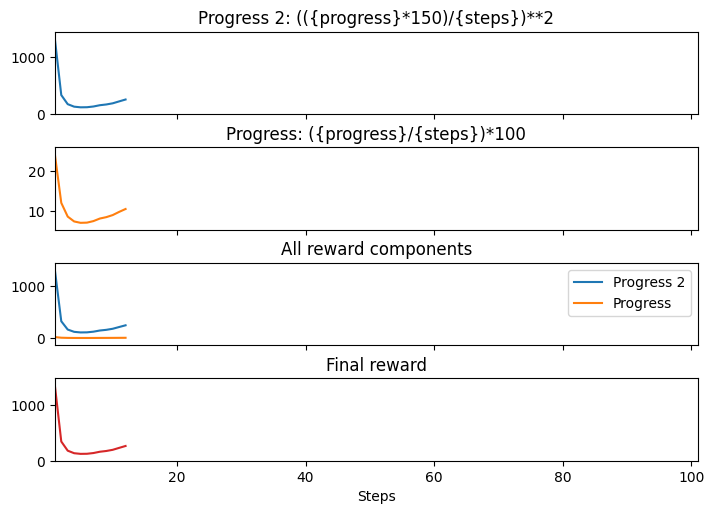

In [20]:
simulation_size = (640, 500)

# Example of reward function components to be analyzed. Dictionary with schema "title": "expression"
reward_components = {
    # "Speed": "{speed}**2",
    "Progress 2": "(({progress}*150)/{steps})**2",
    "Progress": "({progress}/{steps})*100",
    # "Penalize off_track": "(-20 if {episode_status}=='off_track' else 0)"
}

# Instantiate the Simulation
sim = Simulation(model_path, evaluation_df_path, video_path, simulation_size, reward_components_input=reward_components)

# Run simulation until the last frame is reached
while sim.frame_number < sim.total_frame_count:
    if sim.quit:
        break

    while True:
        
        # Check for keyboard strokes (user commands)
        sim.listen_for_key_strokes()
        
        if sim.quit:
            # If any recording underway, the close it first
            if sim.record_simulation:
                sim.record_video_obj.release()
                sim.record_simulation = False
            break

        if sim.pause:
            if(sim.frame_update == 0):
                sim.update_simulation_display(False)
            else:
                # If during pause, user changes frame, update frame here
                sim.frame_number += sim.frame_update
                sim.frame_update = 0
                sim.update_simulation_display()
            continue

        # These key strokes are not allowed during pause, that's why they follow the pause
        sim.listen_for_key_strokes_after_pause()

        # If enough time has passed (considering the frame rate) since the last frame update, then update again
        time_elapsed = time.time() - sim.last_time_checkpoint
        if time_elapsed > 1./sim.frame_rate:
            sim.last_time_checkpoint = time.time()  # reset time
            
            frame = sim.update_simulation_display()
            break   # break from While(True)
        
    sim.frame_number +=1    # Advance frame

# If any recording underway, the close it first
if sim.record_simulation:
    sim.record_video_obj.release()
    sim.record_simulation = False
    
# Present the closing frame:
success, frame = sim.video.read()
sim.write_text_with_border(frame, "Press any key to exit", (30, sim.window_h//2), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), (0,0,0), 2, 3)
cv2.imshow(video_path, frame)
cv2.waitKey()

# Close video and windows
sim.video.release()
cv2.destroyAllWindows()